In [137]:
import numpy as np
from scipy.stats import halfnorm
from scipy.stats import expon
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

In [2]:
class Simulator:
    def __init__(self, nu: int, gamma: int, sigma_min: float, sigma_max: float,
                 x: callable, func: callable, ineff_dist: str = 'half-normal'):
        """
        Simulation class for stochastic frontier meta-analysis.
        
        nu
            The scale of the inefficiency term
        gamma
            The variance of the random effect term
        sigma_min, sigma_max
            The study-specific errors, max and minimum. They will be drawn from a uniform distribution.
        x
            A callable function to generate a realization from a random variable x (is the covariate used
            to construct the frontier). Needs to have an argument size.
        func
            A function of x that defines the frontier
        ineff_dist
            Inefficiency distribution
        """
        self.nu = nu
        self.gamma = gamma
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.x = x
        self.func = func
        
        if ineff_dist == 'half-normal':
            self.rvs = halfnorm.rvs
        elif ineff_dist == 'exponential':
            self.rvs = expon.rvs
        else:
            raise RuntimeError("Inefficiency distribution must be half-normal or exponential")
    
    def simulate(self, n: int = 1, **kwargs):
        sigma = stats.uniform.rvs(loc=self.sigma_min, scale=self.sigma_max, size=n)
        epsilon = stats.norm.rvs(loc=0, scale=sigma, size=n)
        
        us = stats.norm.rvs(loc=0, scale=self.gamma, size=n)
        vs = self.rvs(scale=self.nu, size=n)
        
        xs = self.x(size=n, **kwargs)
        front = self.func(xs)
        observed = front + us - vs + epsilon
        return us, vs, epsilon, xs, front, observed

In [119]:
np.random.seed(150)

In [127]:
s = Simulator(nu=1, gamma=0.25, sigma_min=0, sigma_max=0.75, 
              x=lambda size: stats.uniform.rvs(size=size, loc=0.5), func=lambda x: np.log(x) + 10)
us, vs, epsilon, xs, front, observed = s.simulate(n = 30)

x_front = np.linspace(xs.min(), xs.max())
y_front = s.func(np.linspace(xs.min(), xs.max()))

ymin = observed.min() - 0.5
ymax = observed.max() + 0.5

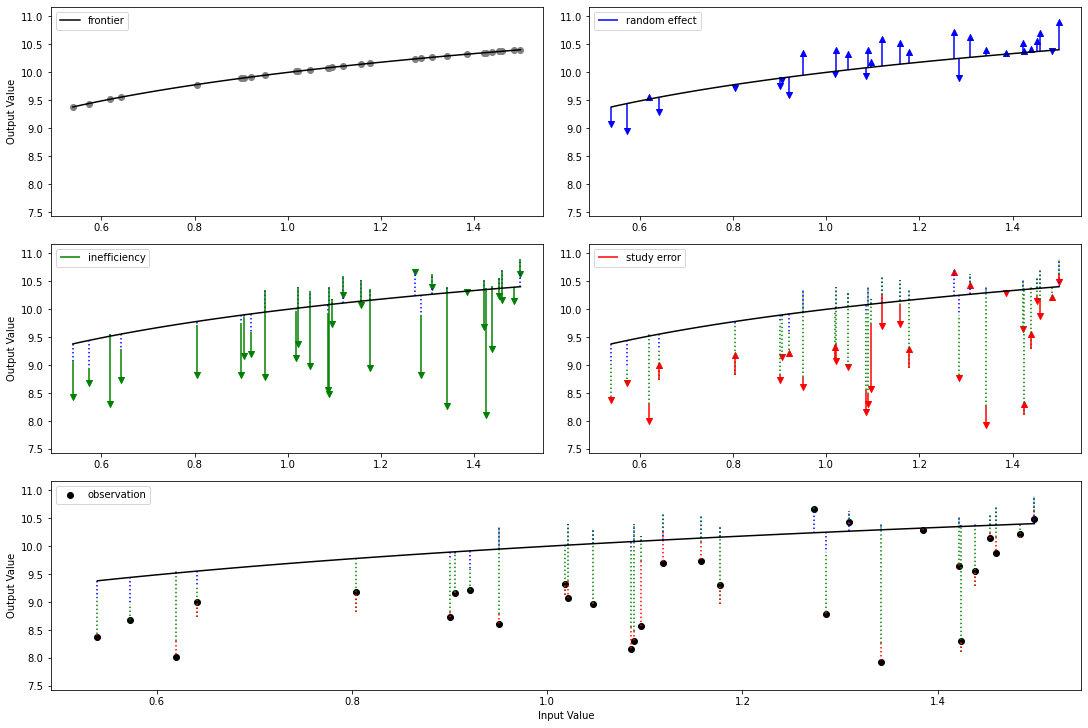

In [169]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0, :-1])
ax1 = fig.add_subplot(gs[0, -1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[1, -1])
ax4 = fig.add_subplot(gs[2, :])

ax0.scatter(xs, front, color='grey')
ax0.plot(x_front, y_front, color='black', label='frontier')
ax0.set_ylim([ymin, ymax])
ax0.legend(loc='upper left')
ax0.set_ylabel("Output Value")

ax1.plot(x_front, y_front, color='black')
ax1.vlines(xs, ymin=front, ymax=front+us, color='blue', label='random effect')
pos_change = us > 0
ax1.scatter(xs[pos_change], (front+us)[pos_change], color='blue', marker='^')
ax1.scatter(xs[~pos_change], (front+us)[~pos_change], color='blue', marker='v')
ax1.set_ylim([ymin, ymax])
ax1.legend(loc='upper left')

ax2.plot(x_front, y_front, color='black')
ax2.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':')
ax2.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', label='inefficiency')
ax2.scatter(xs, front+us-vs, color='green', marker='v')
ax2.set_ylim([ymin, ymax])
ax2.legend(loc='upper left')
ax2.set_ylabel("Output Value")

ax3.plot(x_front, y_front, color='black')
ax3.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':')
ax3.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', linestyle=':')
ax3.vlines(xs, ymin=front+us-vs, ymax=front+us-vs+epsilon, color='red', label="study error")
pos_change = epsilon > 0
ax3.scatter(xs[pos_change], (front+us-vs+epsilon)[pos_change], color='red', marker='^')
ax3.scatter(xs[~pos_change], (front+us-vs+epsilon)[~pos_change], color='red', marker='v')
ax3.set_ylim([ymin, ymax])
ax3.legend(loc='upper left')

ax4.scatter(xs, front+us-vs+epsilon, color='black', label='observation')
ax4.plot(x_front, y_front, color='black')
ax4.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':')
ax4.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', linestyle=':')
ax4.vlines(xs, ymin=front+us-vs, ymax=front+us-vs+epsilon, color='red', linestyle=':')
ax4.set_ylim([ymin, ymax])
ax4.legend(loc='upper left')
ax4.set_xlabel("Input Value")
ax4.set_ylabel("Output Value")

plt.savefig("data-generating-process.pdf")